<a href="https://colab.research.google.com/github/Nathan-Bush46/AIPI-Interpretable-ML/blob/main/assignments/machine_learning_court.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [ ]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count',
            'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [ ]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)

Prediction for Malik Johnson (Recidivism): [0]


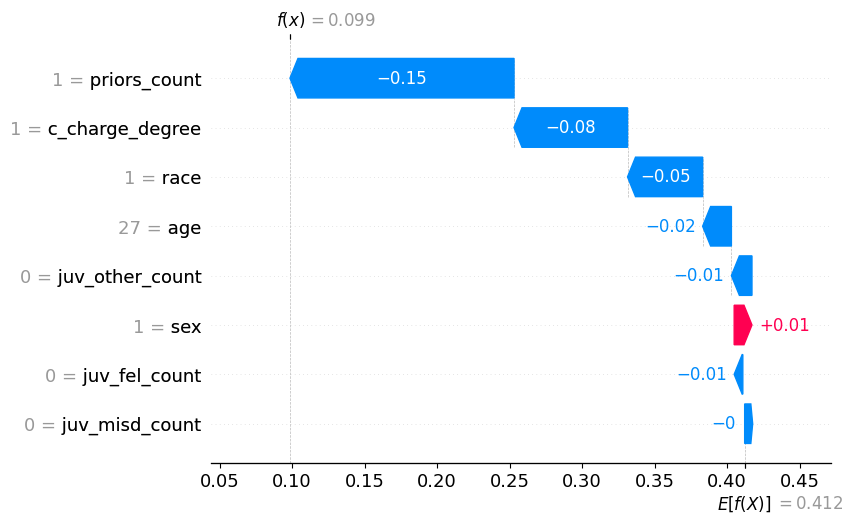

 93%|=================== | 372/400 [00:14<00:01]       

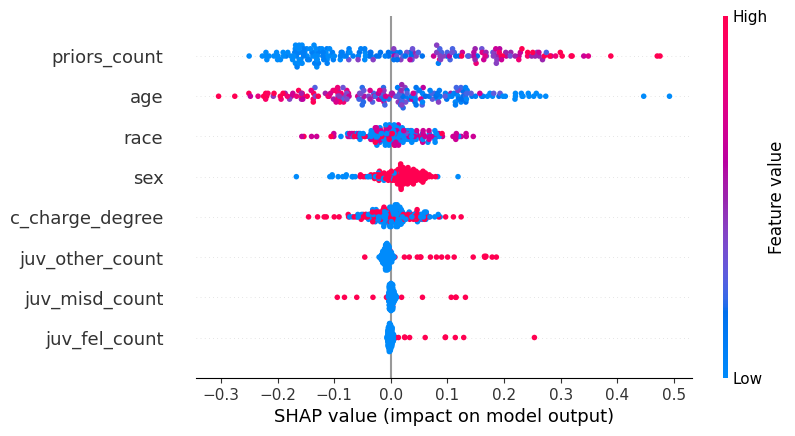

In [ ]:
import shap

# Build unified SHAP explainer
explainer = shap.Explainer(model_compas, X_train)

# ---------------------------
# ✅ Local explanation (Malik Johnson)
# ---------------------------
shap_values_focus = explainer(focus_instance_compas)

# Pick the "Recidivism" class (index 1)
shap.plots.waterfall(shap_values_focus[0, :, 1])

# ---------------------------
# ✅ Global explanation (sample of test set)
# ---------------------------
sample_X = X_test.sample(200, random_state=42)
shap_values_sample = explainer(sample_X)

# Beeswarm for class 1 only
shap.plots.beeswarm(shap_values_sample[:, :, 1])

In [ ]:
import pandas as pd

# Get Malik Johnson's SHAP values
shap_values_focus = explainer(focus_instance_compas)

# Select the "Recidivism" class (index 1)
malik_expl = shap_values_focus[0, :, 1]

# Combine into DataFrame for readability
shap_df = pd.DataFrame({
    "feature": focus_instance_compas.columns,
    "value": focus_instance_compas.values[0],
    "shap_value": malik_expl.values
}).sort_values("shap_value", key=abs, ascending=False)

# Show top 5
print(shap_df.head(5))

           feature  value  shap_value
3     priors_count      1   -0.154497
7  c_charge_degree      1   -0.078268
2             race      1   -0.051789
0              age     27   -0.019837
6  juv_other_count      0   -0.014189


Interpretation (SHAP)

- priors_count = 1 → strong push away from recidivism (−0.15)
- c_charge_degree = felony → moderate push away from recidivism (−0.08)
- race = African-American (coded 1) → smaller push away from recidivism (−0.05)
- age = 27 → slight push away from recidivism (−0.02)
- juv_other_count = 0 → small push away from recidivism (−0.01)

Overall

SHAP is saying:
- Malik’s limited prior history (just 1 prior) is the strongest reason the model predicts low risk.
- His felony charge and dataset-coded race both contribute further to lowering the prediction.
- His age and clean juvenile record add smaller downward pushes.
- All major contributions are negative, pulling the prediction from the dataset baseline (≈0.41) down to ≈0.10.
- The model therefore sees Malik as substantially less likely to reoffend compared to the average case.


[('juv_fel_count <= 0.00', -0.14013218632087515), ('0.00 < priors_count <= 2.00', -0.10364431635544975), ('juv_other_count <= 0.00', -0.06771198368821896), ('juv_misd_count <= 0.00', -0.06442535430130347), ('25.00 < age <= 31.00', 0.04201523388912158)]


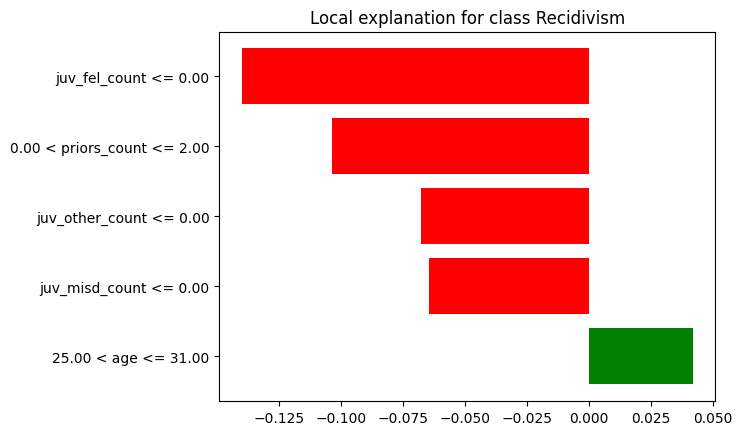

In [ ]:
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular

# Build LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=["No Recidivism", "Recidivism"],
    mode="classification"
)

# Explain Malik Johnson’s case
lime_exp = lime_explainer.explain_instance(
    focus_instance_compas.to_numpy()[0],
    lambda x: model_compas.predict_proba(
        pd.DataFrame(x, columns=X_train.columns)),
    num_features=5
)


# Text explanation
print(lime_exp.as_list())

# Matplotlib figure (works in any Python script)
fig = lime_exp.as_pyplot_figure()
plt.show()

Interpretation lime

- juv_fel_count = 0 (no juvenile felonies) → strong push away from recidivism (−0.14)
- priors_count = 1 (a small number of prior offenses) → moderate push away from recidivism (−0.10)
- juv_other_count = 0 (no other juvenile charges) → smaller push away (−0.07)
- juv_misd_count = 0 (no juvenile misdemeanors) → smaller push away (−0.06)
- age = 27 (in 25–31 range) → slight push toward recidivism (+0.04)

Overall
- Malik’s clean juvenile record (felonies, misdemeanors, other charges all = 0) is the strongest reason the model predicts low risk.
- Having just 1 prior adult offense reduces his risk classification compared to people with many priors.
- His age (27) adds a tiny bit of risk in the model’s eyes, but not nearly enough to outweigh the clean record.


Note: In this case, SHAP shows age 27 slightly lowers Malik’s predicted risk compared to the dataset average, while LIME shows it slightly raises risk compared to nearby profiles. This highlights that each tool answers a very specific question, and neither alone shows the full picture of how a parameter influences the model’s behavior. XAI is still a work in progress, and these tools need further development before they can be considered fully reliable or broadly useful.

### Case Summary – Individual Analysis (Recidivism, Malik Johnson)

Using SHAP and LIME, I examined the model’s prediction for Malik Johnson.  
Both methods agree that his **limited prior record** and **clean juvenile history** are the strongest factors pushing his risk down.  

- SHAP shows that all major contributions (priors, charge degree, race, age, juvenile counts) lowered his predicted risk, reducing it from the dataset baseline (~41%) to about 10%.  
- LIME also highlights his clean juvenile record and few priors as the dominant protective features, though it differs slightly on age (showing it as a small positive factor).  

**Overall:** Both explanations support the conclusion that the model views Malik Johnson as substantially **lower risk than average**, with priors and juvenile history being decisive. Minor disagreements between SHAP and LIME illustrate that XAI tools answer different questions and should be interpreted cautiously.


#### 🟦 Defense one liner

The model appears valid in Malik Johnson’s case, since both SHAP and LIME show his limited priors and clean juvenile record drive a low-risk prediction, which aligns with what we would expect from a well-functioning model.